In [3]:
# import dependencies
# import pyreadr
# import rdata
import pandas as pd
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split
from prophet import Prophet


In [4]:
df = pd.read_csv("./Resources/mi-cleaned-final.csv")
df.head()

,Unnamed: 0,Date,FIPS Code-County,Min Ambient Temp,Max Ambient Temp,Mean Ambient Temp,Min Dew Point,Max Dew point,Mean Dew Point,Min Heat Index,...,Mean WBGT,Min Relative_Humidity,Max Relative_Humidity,Mean Relative_Humidity,DTR,Low Threat,Elevated Threat,Moderate Threat,High Threat,Extreme Threat
0,0,2000-01-02,26001,30.326,45.014000,36.824,28.652,43.844000,36.104,30.326,...,36.032,0.934051,0.956410,0.971976,14.688000,1,0,0,0,0
1,1,2000-01-02,26003,23.972,31.136000,27.662,19.616,28.778000,24.584,23.972,...,26.150,0.831948,0.908560,0.880373,7.164000,1,0,0,0,0
2,2,2000-01-02,26005,37.742,53.419999,45.986,35.258,48.397999,43.196,37.544,...,45.032,0.906604,0.830344,0.899241,15.677999,1,0,0,0,0
3,3,2000-01-02,26007,27.356,43.034000,35.780,24.962,42.080000,34.790,27.356,...,35.006,0.905671,0.964018,0.961469,15.678000,1,0,0,0,0
4,4,2000-01-02,26009,27.878,43.376000,35.330,25.610,40.712000,32.972,27.878,...,34.070,0.910638,0.902519,0.910216,15.498000,1,0,0,0,0


In [5]:
df.columns

Index(['Unnamed: 0', 'Date', 'FIPS Code-County', 'Min Ambient Temp',
       'Max Ambient Temp', 'Mean Ambient Temp', 'Min Dew Point',
       'Max Dew point', 'Mean Dew Point', 'Min Heat Index', 'Max Heat Index',
       'Mean Heat Index', 'Min WBGT', 'Max WBGT', 'Mean WBGT',
       'Min Relative_Humidity', 'Max Relative_Humidity',
       'Mean Relative_Humidity', 'DTR', 'Low Threat', 'Elevated Threat',
       'Moderate Threat', 'High Threat', 'Extreme Threat'],
      dtype='object')

In [6]:
# Convert integer dates to datetime format
df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y-%m-%d')
df.set_index("Date", inplace=True)

#drop columns with no data ("Flag_")

columns_to_drop = [col for col in df.columns if (df[col] == 0.0).all()]
df = df.drop(columns_to_drop, axis=1)

if df.columns.__contains__('Flag_UTCI'):
    df = df.drop(['Flag_UTCI'], axis=1)

if df.columns.__contains__('StCoFIPS'):
    df = df.drop(['StCoFIPS'], axis=1)

if df.columns.__contains__('Unnamed: 0'):
    df = df.drop(['Unnamed: 0'], axis=1)

# Define conversion functions
def celsius_to_fahrenheit(celsius):
    return celsius * 9/5 + 32

# Apply conversion
df = df.map(celsius_to_fahrenheit)

<Axes: xlabel='Date'>

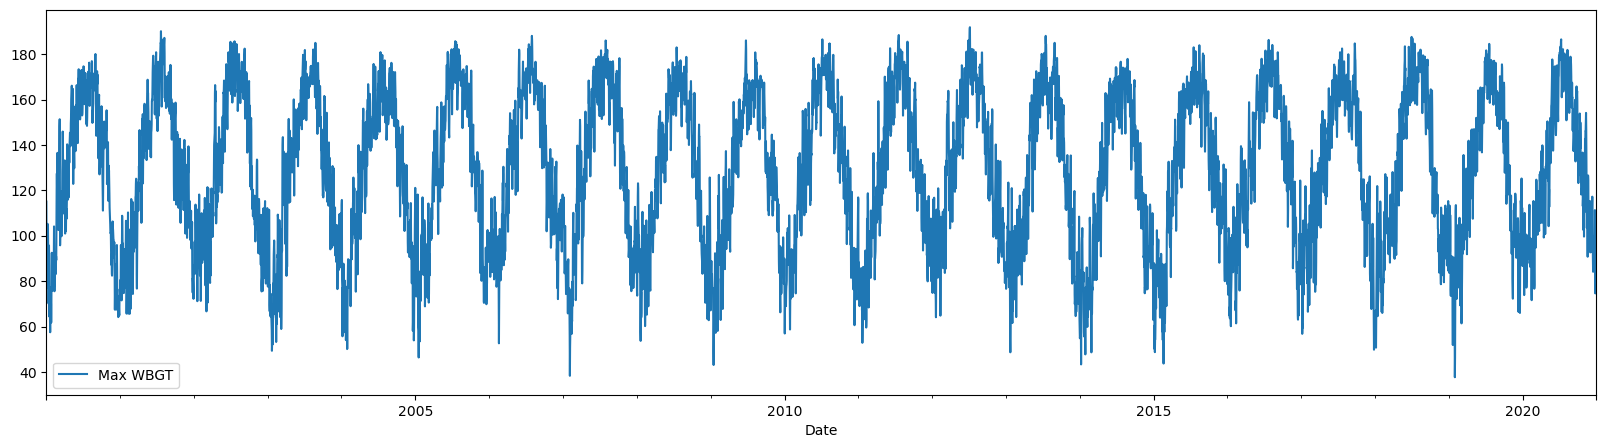

In [7]:
# We need to combine the values for all regions into a statewide average to chart the wet bulb temp
wet_bulb_df = df.copy()
wet_bulb_df.drop(columns=df.columns.difference(['Max WBGT']), inplace=True)
wet_bulb_df = wet_bulb_df.groupby(by='Date').mean()
wet_bulb_df.plot(figsize=(20,5))

19:40:35 - cmdstanpy - INFO - Chain [1] start processing
19:40:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\jerom\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jerom\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


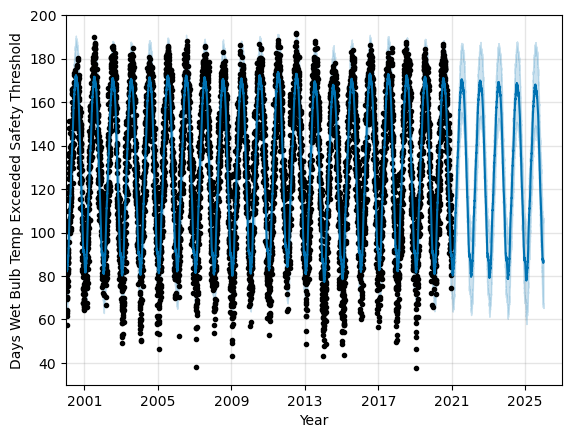

In [8]:
# Calculate the future using Prophet

wet_bulb_df = wet_bulb_df.reset_index().rename(columns={'Date': 'ds', 'Max WBGT': 'y'})
y = wet_bulb_df['y']

X = wet_bulb_df.copy()

# Prophet
prophet = Prophet()
prophet.fit(X)

future = prophet.make_future_dataframe(periods=365*5, freq="D")
forecast = prophet.predict(future)

axis = plt.axes()
axis.set_xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2026-12-31"))
axis.set_ylim(30, 200)

fig = prophet.plot(forecast, ax=axis, xlabel='Year', ylabel='Days Wet Bulb Temp Exceeded Safety Threshold', figsize=(20,5))



In [9]:
# Merge actual and forecasted data for evaluation
forecast = forecast[['ds', 'yhat']].set_index('ds')
actual = wet_bulb_df.set_index('ds')['y']  # Ensure 'y' is the actual target column in your data

# Combine actual and forecasted data
df_merged = actual.to_frame().join(forecast)
df_merged.dropna(inplace=True)  # Drop rows where either actual or predicted is missing


In [10]:
# Evaluate model using  Calculate MAPE (Mean Absolute Percentage Error)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


mape = np.mean(np.abs((df_merged['y'] - df_merged['yhat']) / df_merged['y'])) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

 # Calculate MAE
mae = mean_absolute_error(df_merged['y'], df_merged['yhat'])
print(f'Mean Absolute Error (MAE): {mae:.3f}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_merged['y'], df_merged['yhat']))
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')

Mean Absolute Percentage Error (MAPE): 9.33%
Mean Absolute Error (MAE): 10.415
Root Mean Squared Error (RMSE): 13.093
